## 01. 네트워크 분석 기초

- 실제 데이터 사용 x

- 작성자 : 권도희

- 최종수정일 : 2025.12.08

[수정이력]

- 2025.12.05 : 최초작성

- 2025.12.07 : 20x20 네트워크 확장 Dijkstra vs A* 추가

- 2025.12.08 : 20x20 네트워크 엣지 생성방식 수정 (중앙에 가중치 낮게 + 미세 noise 추가)

               휴리스틱 스케일 비교

               네트워크 복잡성 추가 및 휴리스틱 스케일 비교(random geometric graph) 

In [23]:
# 사용 라이브러리 정리
import pandas as pd
import numpy as np
import os
import math
import time
import random

## 딕셔너리 자동생성
from collections import defaultdict

## 네트워크 분석용 라이브러리
import networkx as nx

## 우선순위 큐 탐색
import heapq

## 그래프 생성용 라이브러리
import matplotlib.pyplot as plt



### 1. 네트워크 분석 기본

- 네트워크 분석(Network Analysis) : 노드(지점)와 엣지(연결·도로·관계)로 구성된 구조를 수학적으로 표현하고, 그 위에서 흐름·경로·전이·접근성 등을 계산하는 방법

- 네트워크 분석의 활용영역 :

1) 구조적 분석(Topology)
    - 네트워크의 형태·특성을 파악
    
2) 경로 기반 분석 (Shortest Path/ Routing)
    - A -> B 까지 가장 비용이 낮은 경로 탐색
    - Dijkstra 알고리즘 등 활용

3) 흐름분석(Flow/Transition)
    - 네트워크 위에서 데이터가 어떻게 이동하는지 계산
    - 전이확률기반 유입량, 수송, 교통량 계산 등

본 자료에서는 2) 경로 기반 분석을 중심으로 서술

### 2. 경로분석 시뮬레이션 방법

- 본 자료에서는 경로분석의 기본 알고리즘 및 예시를 시뮬레이션을 통해 설명

1) 데이터 생성 : 노드 및 연결성(엣지) 생성

2) 네트워크 속성 설정 : 노드 혹은 엣지에 가중치를 부여

3) 경로탐색 실행 : 각 알고리즘별 경로탐색의 결과 비교

[경로분석 알고리즘 종류]

1) Dijkstra 알고리즘 : 아직 확정되지 않은 노드 중 가장 작은 거리를 가진 노드를 하나씩 확장

    => 지금까지 진행했던 경로의 누적거리(혹은 가중치)를 갱신하면서 누적거리가 짧은 경로를 선택하도록 변경되는 알고리즘

    => 가중치 값이 음수인 경우가 아니라면 정확도가 보장됨

    => 계산 효율은 가중치 분포가 극단적으로 편향되어 있거나, 가중치들의 값 차이가 거의 없을때 하락함

2) Floyd-Warshall 알고리즘 : 모든 노드쌍의 최단거리를 한번에 구함

    => 출발지-> 목적지 까지의 직접 거리를 계산하고, 다른 노드를 거치는 경로와 비교해서 더 짧은 거리를 선택

    => 모든 경우를 다 고려하기 때문에 계산 효율이 매우 떨어짐


3) A*(A-star) 알고리즘 : Dijkstra 알고리즘의 누적 거리에 현재노드-목적지노드 간 거리(유클리드 혹은 맨해튼)를 가중치로 추가로 부여

    => 추가된 가중치는 경로 길이에 영향을 주는 것이 아님. 다만, 다음 탐색 경로에 우선순위를 부여

    => 정확도는 Dijkstra와 다르지 않음. 다만 탐색 폭이 줄어서 훨씬 속도가 빠름


4) D*(Dynamic A*) 알고리즘 : A*알고리즘을 동적 상태에서 반영할 수 있도록 만든 버전

    => 실시간 경로탐색에 활용가능. 중간에 경로의 가중치가 바뀌는 경우 (예 : 사고발생) 기존의 누적거리를 반영하되, 남은 거리를 새로 계산

    => 가중치가 바뀐 노드/엣지만 A*방식으로 재탐색

    => 이론적으로는 완벽하나, 실제 데이터에 반영할 경우 구현난이도가 매우 높음


- 현대에와서 D*의 구현난이도를 낮게/성능향상을 목표로 발전된 알고리즘들이 많으며, 창고내부이동로봇, 군사용 드론, 우주공간 탐사 등의 분야에 사용됨

- 현대의 네비게이션은 코드의 유지보수 용이성, 동적인 변화를 많이 요구하지 않는 도로환경 등을 이유로 A*기반의 알고리즘을 주로 사용함

- 자율주행 자동차의 경우, 전역경로탐색은 네비게이션과 같은 A*, 국지적 경로탐색은 센서감지기반의 알고리즘을 사용함

### 3. 시뮬레이션

#### 3-1. 2 x 2미니 네트워크

- 4개의 노드가 인접 2개의 노드에만 연결됨

- 노드 4개, 엣지 4개인 사각형의 네트워크 형태

In [ ]:
## 기본 네트워크 구성 행렬

net1 = np.array([
  [0, 1, 1, 0],
  [1, 0, 0, 1],
  [1, 0, 0, 1],
  [0, 1, 1, 0]
])

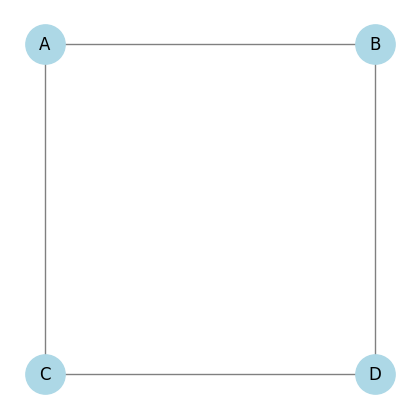

In [ ]:
## 그래프생성

G = nx.from_numpy_array(net1)

# 노드 좌표 직접 배치 (2x2 grid)
pos = {
     0: (0, 1),
     1: (1, 1),
     2: (0, 0),
     3: (1, 0)
}

# 라벨 매핑 (0→A, 1→B, 2→C, 3→D)
labels = {0: "A", 1: "B", 2: "C", 3: "D"}

# 시각화
plt.figure(figsize=(4,4))
nx.draw(
    G, pos,
    with_labels=False,
    node_size=800,
    node_color="lightblue",
    font_size=12,
    edge_color="gray"
)
# 커스텀 라벨 적용
nx.draw_networkx_labels(G, pos, labels, font_size=12)

plt.show()

In [ ]:
## 가중치 속성 부여
weight1 = np.array([
  [0, 1, 2, 0],   # A
  [1, 0, 0, 3],   # B
  [2, 0, 0, 4],   # C
  [0, 3, 4, 0]    # D
])

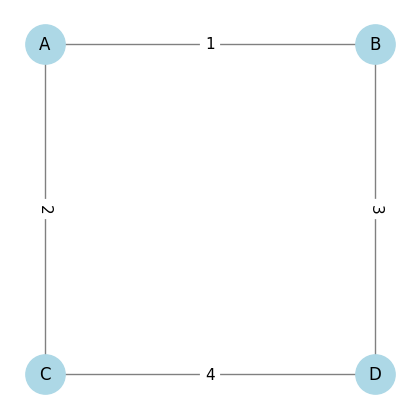

In [ ]:
## 가중치가 부여된 그래프의 시각화

G = nx.from_numpy_array(weight1)

# 노드 좌표 직접 배치 (2x2 grid)
pos = {
     0: (0, 1),
     1: (1, 1),
     2: (0, 0),
     3: (1, 0)
}

# 라벨 매핑 (0→A, 1→B, 2→C, 3→D)
labels = {0: "A", 1: "B", 2: "C", 3: "D"}

edge_labels = nx.get_edge_attributes(G, "weight")

# 시각화
plt.figure(figsize=(4,4))
nx.draw(
    G, pos,
    with_labels=False,
    node_size=800,
    node_color="lightblue",
    font_size=12,
    edge_color="gray"
)
# 커스텀 라벨 적용
nx.draw_networkx_labels(G, pos, labels, font_size=12)
# 엣지 라벨(가중치)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=11)

plt.show()

In [ ]:
## 다익스트라 알고리즘을 활용한 최단거리 추출
## 기존의 weight1 행렬을 그대로 사용
## 탐색할 경로는 A-> D


# 그래프 생성
G = nx.Graph()

# 노드 이름을 A,B,C,D로 직접 사용
nodes = ["A", "B", "C", "D"]
G.add_nodes_from(nodes)

# 엣지 + 가중치 (앞에서 만든 W 행렬 동일)
G.add_edge("A", "B", weight=1)
G.add_edge("A", "C", weight=2)
G.add_edge("B", "D", weight=3)
G.add_edge("C", "D", weight=4)

# 다익스트라로 최단경로 계산
path = nx.dijkstra_path(G, source="A", target="D", weight="weight")
distance = nx.dijkstra_path_length(G, source="A", target="D", weight="weight")

print("최단경로:", path)
print("최단거리:", distance)

최단경로: ['A', 'B', 'D']
최단거리: 4


In [ ]:
## 다익스트라 알고리즘이 최단거리를 추출하는 과정 함수

def dijkstra_trace_nx(G, start):
    nodes = list(G.nodes())
    idx = {n: i for i, n in enumerate(nodes)}  # 이름→인덱스 매핑
    rev = {i: n for n, i in idx.items()}       # 인덱스→이름

    n = len(nodes)
    INF = math.inf

    dist = [INF] * n
    prev = [None] * n
    visited = [False] * n

    s = idx[start]
    dist[s] = 0

    visited_order = []
    relax_logs = []

    for _ in range(n):
        # 아직 방문 안 한 노드 중 dist 최소인 u 선택
        u = -1
        min_dist = INF
        for i in range(n):
            if not visited[i] and dist[i] < min_dist:
                min_dist = dist[i]
                u = i

        if u == -1:
            break

        visited[u] = True
        visited_order.append(rev[u])

        # u와 이웃한 노드들에 대해 relaxation
        for v_name in G.neighbors(rev[u]):
            v = idx[v_name]
            if visited[v]:
                continue

            w = G[rev[u]][v_name]["weight"]
            new_dist = dist[u] + w
            if dist[v] > new_dist:
                relax_logs.append({
                    "from": rev[u],
                    "to": v_name,
                    "old_dist": dist[v],
                    "new_dist": new_dist,
                })
                dist[v] = new_dist
                prev[v] = u

    return dist, prev, visited_order, relax_logs, rev


def reconstruct_path_from_prev(prev, rev, start_name, goal_name):
    # 이름 → 인덱스는 다시 만들어도 되고, 위에서 같이 넘겨도 됨
    name_to_idx = {rev[i]: i for i in rev}
    start = name_to_idx[start_name]
    goal = name_to_idx[goal_name]

    path_idx = []
    cur = goal
    while cur is not None:
        path_idx.append(cur)
        if cur == start:
            break
        cur = prev[cur]

    if not path_idx or path_idx[-1] != start:
        return None

    path_idx.reverse()
    return [rev[i] for i in path_idx]

In [ ]:
dist, prev, visited_order, relax_logs, rev = dijkstra_trace_nx(G, start="A")
path = reconstruct_path_from_prev(prev, rev, "A", "D")

print("방문 순서:", " -> ".join(visited_order))
print("최단 경로 A->D:", " -> ".join(path))

print("\nRelaxation 로그:")
for log in relax_logs:
    print(f"{log['from']} -> {log['to']} : {log['old_dist']} → {log['new_dist']}")

방문 순서: A -> B -> C -> D
최단 경로 A->D: A -> B -> D

Relaxation 로그:
A -> B : inf → 1
A -> C : inf → 2
B -> D : inf → 4


#### 3-2. 네트워크 규모 확장 

##### 3-2-1. 20 x 20 grid 형태 네트워크 (랜덤 엣지)

In [ ]:
## 네트워크 생성 함수
## 엣지 가중치는 정규분포에서 추출

def build_grid_graph(n = 20, mean = 100, std = 20, seed=None):
    """
    n x n 격자 그래프 생성
    인접한 노드들 사이에 정규분포 N(mean, std)에서 뽑은 weight 부여
    """

    if seed is not None:
        np.random.seed(seed)

    # 4-이웃 격자 그래프 생성 (노드: (x, y))
    G = nx.grid_graph(dim=[n, n])  # undirected

    # 각 엣지에 랜덤 가중치 부여
    for u, v in G.edges():
        w = np.random.normal(mean, std)
        # 음수/0 나오는 것 방지용 (필요 없으면 제거 가능)
        w = max(1, w)
        G.edges[u, v]["weight"] = float(w)

    # A*에서 쓸 수 있도록 좌표를 속성으로도 저장
    for x, y in G.nodes():
        G.nodes[(x, y)]["x"] = x
        G.nodes[(x, y)]["y"] = y

    return G

In [3]:
## 네트워크 생성

G = build_grid_graph(n=20, mean=100, std=20, seed=42)
print(G.number_of_nodes(), G.number_of_edges())

400 760


In [4]:
## Dijkstra와 A*의 비교

## Dijkstra 알고리즘의 최단거리, 방문노드수, 실행시간 
def dijkstra_with_stats(G, source, target, weight="weight"): 
    """
    다익스트라: 최단거리, 방문 노드 수, 실행시간 리턴
    """
    start_t = time.perf_counter() ##함수 실행 시작지점
    prev = {}
    dist = {source: 0.0} #출발지점
    visited = set() #확정된 최단거리
    pq = [(0.0, source)] #우선순위 큐
    visited_count = 0
    visit_count = defaultdict(int) ## 탐색한 순서 기록

    while pq:
        d_u, u = heapq.heappop(pq) ## 우선순위 큐를 끄집어냄 (거리, 노드)
        if u in visited:
            continue
        visited.add(u) #기존 최단거리 경로에서 우선순위 큐를 추가
        visited_count += 1 #탐색한 노드 수 누적시킴
        visit_count[u] += 1 #방문한 노드에 따라 누적

        if u == target: #목적지점에 다다르면 루프 종료
            break

        for v in G.neighbors(u): ## 현재 큐의 이웃 노드
            w_uv = G[u][v].get(weight, 1.0) # 현재의 큐에서 이웃 노드까지의 엣지 가중치
            alt = d_u + w_uv ## 기존 최단거리에 가중치를 추가
            if alt < dist.get(v, float("inf")): # u에서 v로 가중치로 이동한거리(alt) vs v까지의 최단 거리(dist.get)
                dist[v] = alt ## alt가 짧으면 갱신
                prev[v] = u
                heapq.heappush(pq, (alt, v)) ## 우선순위 큐를 갱신

    end_t = time.perf_counter() ##함수 실행 끝지점

    # 최단 경로 복원
    path = []
    cur = target
    if cur in dist:
        while cur != source:
            path.append(cur)
            cur = prev[cur]
        path.append(source)
        path.reverse()

    return {
        "distance": dist.get(target, float("inf")),
        "visited": visited_count,
        "visit_count": visit_count,
        "time_sec": end_t - start_t,
        "path": path
    }

## 맨해튼 거리 함수
def manhattan(p, q):
    return abs(p[0] - q[0]) + abs(p[1] - q[1])

## A* 알고리즘의 최단거리, 방문노드수, 실행시간 
def astar_with_stats(G, source, target, weight="weight", heuristic_scale=1.0):
    """
    A*: 최단거리, 방문 노드 수, 실행시간 리턴
    heuristic_scale은 h(n)=scale * manhattan(n,target)에 곱하는 스케일(휴리스틱 자체 가중치)
    """
    start_t = time.perf_counter() ##함수 실행 시작지점
    prev = {}
    visit_count = defaultdict(int) ## 탐색한 순서 기록
    # g: 실제 비용, f = g + h
    g = {source: 0.0} # 출발지점
    visited = set() # 확정된 최단거리
    visited_count = 0

    def h(node):
        return heuristic_scale * manhattan(node, target)

    pq = [(h(source), source)]  # (f, node)

    while pq:
        f_u, u = heapq.heappop(pq) ##우선순위 큐를 끄집어냄 (휴리스틱, 노드)
        if u in visited:
            continue
        visited.add(u) ##기존 최단거리 경로에서 우선순위 큐를 추가
        visited_count += 1  #탐색한 노드 수 누적시킴
        visit_count[u] += 1 #방문한 노드에 따라 누적
        if u == target: #목적지점에 다다르면 루프 종료
            break

        g_u = g[u] #현재 큐에서의 거리

        for v in G.neighbors(u): #현재 큐와 인접한 노드 v
            w_uv = G[u][v].get(weight, 1.0) ## 현재의 큐에서 이웃 노드까지의 엣지 가중치
            tentative_g = g_u + w_uv ## 기존 최단거리에 가중치를 추가

            if tentative_g < g.get(v, float("inf")): # u에서 v로 가중치로 이동한거리(tentative_g) vs v까지의 최단 거리(g.get)
                g[v] = tentative_g ##기존 최단거리에 가중치를 추가
                f_v = tentative_g + h(v) ## 가중치에 휴리스틱을 추가
                prev[v] = u
                heapq.heappush(pq, (f_v, v)) ## 우선순위 큐를 갱신

    end_t = time.perf_counter() ##함수 실행 끝지점

        # 최단 경로 복원
    path = []
    cur = target
    if cur in g:
        while cur != source:
            path.append(cur)
            cur = prev[cur]
        path.append(source)
        path.reverse()

    return {
        "distance": g.get(target, float("inf")),
        "visited": visited_count,
        "visit_count": visit_count,
        "time_sec": end_t - start_t,
        "path": path
    }


if __name__ == "__main__":
    # -----------------------------
    # 파라미터
    # -----------------------------
    n = 20
    mean = 100
    std = 20
    seed = 42

    # 그래프 생성
    G = build_grid_graph(n=n, mean=mean, std=std, seed=seed)

    ## 노드상 출발지점은 (0,0), 목적지점은 (19,19)
    source = (0, 0) 
    target = (n - 1, n - 1)

    # 휴리스틱 스케일은 대략 평균 가중치 정도로 맞춰줌
    heuristic_scale = mean

    # 다익스트라
    dijkstra_result = dijkstra_with_stats(G, source, target)
    print("=== Dijkstra ===")
    print(f"distance : {dijkstra_result['distance']:.3f}")
    print(f"visited  : {dijkstra_result['visited']}")
    print(f"time_sec : {dijkstra_result['time_sec']:.6f}")

    # A*
    astar_result = astar_with_stats(G, source, target, heuristic_scale=heuristic_scale)
    print("\n=== A* ===")
    print(f"distance : {astar_result['distance']:.3f}")
    print(f"visited  : {astar_result['visited']}")
    print(f"time_sec : {astar_result['time_sec']:.6f}")

    # 두 알고리즘 결과 비교 (거리)
    print("\n=== Compare ===")
    print(f"same distance? {abs(dijkstra_result['distance'] - astar_result['distance']) < 1e-6}")


=== Dijkstra ===
distance : 3261.463
visited  : 400
time_sec : 0.001308

=== A* ===
distance : 3282.794
visited  : 44
time_sec : 0.000217

=== Compare ===
same distance? False


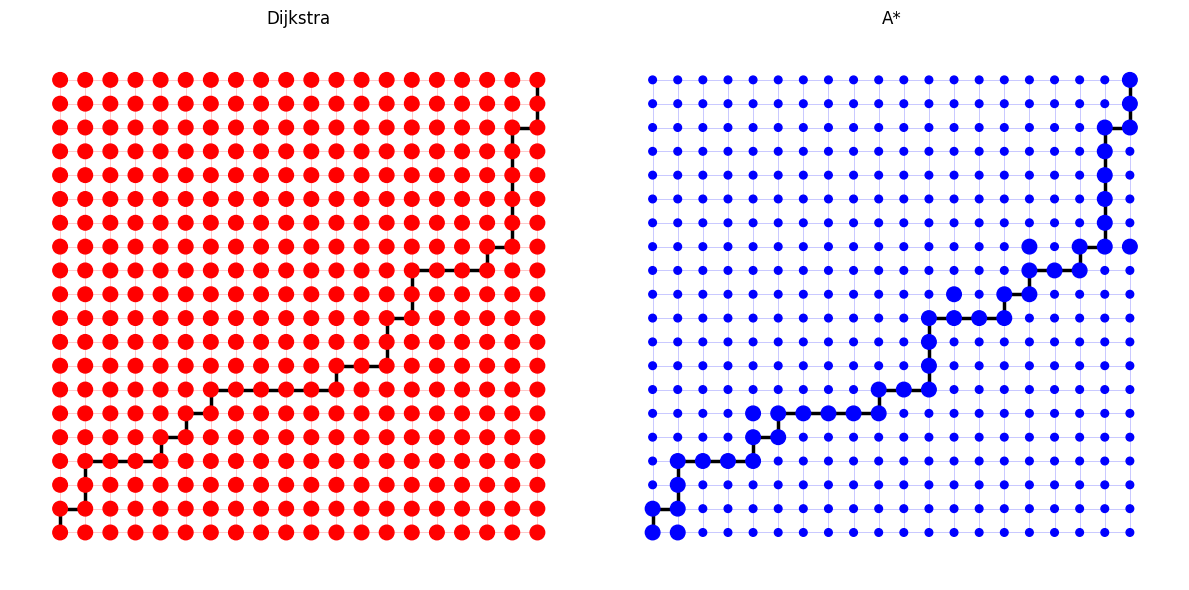

In [6]:
dist_dijkstra = dijkstra_result['distance']
path_dijkstra = dijkstra_result['path']
visit_count_dijkstra = dijkstra_result['visit_count']

dist_astar = astar_result['distance']
path_astar = astar_result['path']
visit_count_astar = astar_result['visit_count']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

pos = {node: node for node in G.nodes()}

def draw_result(ax, title, path, visit_count, noed_color = 'red',edge_color='red'):
    base_size = 30
    sizes = [
        base_size + 80 * visit_count.get(node, 0)  # 방문 많이 할수록 노드 크게
        for node in G.nodes()
    ]

    ax.set_title(title)
    nx.draw_networkx_edges(G, pos, ax=ax, width=0.5, alpha=0.3, edge_color=edge_color)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=sizes, node_color=noed_color)

    # 최단 경로 강조
    if path:
        path_edges = list(zip(path[:-1], path[1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, ax=ax, width=2.5)
    ax.axis("off")

draw_result(axes[0], "Dijkstra", path_dijkstra, visit_count_dijkstra,noed_color='red' ,edge_color="red")
draw_result(axes[1], "A*",       path_astar,     visit_count_astar, noed_color='blue' ,edge_color="blue")

plt.tight_layout()
plt.show()

네트워크의 엣지를 랜덤으로 부여하는 순간, 비용구조에 일관된 의미가 사라짐. 경로결과가 알고리즘 특성을 따라가지 않게 됨.

즉, A*의 heuristic이 실제 비용과 논리적으로 연결되지 않음(hueristic에 대한 가정이 깨짐)

##### 3-2-2. 20 x 20 grid 형태 네트워크 (중앙은 가중치 낮게, 외곽에는 가중치 높게)

In [74]:
## 네트워크 생성 함수 수정
## 엣지 가중치가 동일하여, Dijkstra와 A*의 탐색성능만 비교하도록

def build_grid_graph(n=20, m=20):
    G = nx.grid_graph(dim=[n, m])  # 노드: (x, y)

    cx, cy = (n - 1) / 2, (m - 1) / 2

    # 1) 노드별 "비용" 계산해서 저장
    for (x, y) in G.nodes():
        rx = x - cx
        ry = y - cy

        
        # 중심에서 멀어질수록 cost 증가
        node_cost = 100 + max(1,(abs(rx) - abs(ry)) )+ abs(random.gauss(0, 0.1))

        G.nodes[(x, y)]["x"] = x
        G.nodes[(x, y)]["y"] = y
        G.nodes[(x, y)]["cost"] = node_cost

    # 2) 각 엣지 weight = 양 끝 노드 cost의 평균 (혹은 최소, 최대 등)
    for u, v in G.edges():
        c_u = G.nodes[u]["cost"]
        c_v = G.nodes[v]["cost"]

        w = max(1.0, (c_u + c_v) / 2.0)
        G.edges[u, v]["weight"] = float(w)

    return G

In [75]:
G = build_grid_graph(n=20, m=20)
print(G.number_of_nodes(), G.number_of_edges())

400 760


In [93]:
## Dijkstra와 A*의 비교

## Dijkstra 알고리즘의 최단거리, 방문노드수, 실행시간 
def dijkstra_with_stats(G, source, target, weight="weight"): 
    """
    다익스트라: 최단거리, 방문 노드 수, 실행시간 리턴
    """
    start_t = time.perf_counter() ##함수 실행 시작지점
    prev = {}
    dist = {source: 0.0} #출발지점
    visited = set() #확정된 최단거리
    pq = [(0.0, source)] #우선순위 큐
    visited_count = 0
    visit_count = defaultdict(int) ## 탐색한 순서 기록

    while pq:
        d_u, u = heapq.heappop(pq) ## 우선순위 큐를 끄집어냄 (거리, 노드)
        if u in visited:
            continue
        visited.add(u) #기존 최단거리 경로에서 우선순위 큐를 추가
        visited_count += 1 #탐색한 노드 수 누적시킴
        visit_count[u] += 1 #방문한 노드에 따라 누적

        if u == target: #목적지점에 다다르면 루프 종료
            break

        for v in G.neighbors(u): ## 현재 큐의 이웃 노드
            w_uv = G[u][v].get(weight, 1.0) # 현재의 큐에서 이웃 노드까지의 엣지 가중치
            alt = d_u + w_uv ## 기존 최단거리에 가중치를 추가
            if alt < dist.get(v, float("inf")): # u에서 v로 가중치로 이동한거리(alt) vs v까지의 최단 거리(dist.get)
                dist[v] = alt ## alt가 짧으면 갱신
                prev[v] = u
                heapq.heappush(pq, (alt, v)) ## 우선순위 큐를 갱신

    end_t = time.perf_counter() ##함수 실행 끝지점

    # 최단 경로 복원
    path = []
    cur = target
    if cur in dist:
        while cur != source:
            path.append(cur)
            cur = prev[cur]
        path.append(source)
        path.reverse()

    return {
        "distance": dist.get(target, float("inf")),
        "visited": visited_count,
        "visit_count": visit_count,
        "time_sec": end_t - start_t,
        "path": path
    }

## 맨해튼 거리 함수
def manhattan(p, q):
    return abs(p[0] - q[0]) + abs(p[1] - q[1])

## A* 알고리즘의 최단거리, 방문노드수, 실행시간 
def astar_with_stats(G, source, target, weight="weight", heuristic_scale=1.0):
    """
    A*: 최단거리, 방문 노드 수, 실행시간 리턴
    heuristic_scale은 h(n)=scale * manhattan(n,target)에 곱하는 스케일(휴리스틱 자체 가중치)
    """
    start_t = time.perf_counter() ##함수 실행 시작지점
    prev = {}
    visit_count = defaultdict(int) ## 탐색한 순서 기록
    # g: 실제 비용, f = g + h
    g = {source: 0.0} # 출발지점
    visited = set() # 확정된 최단거리
    visited_count = 0

    def h(node):
        return heuristic_scale * manhattan(node, target)
    
    pq = [(h(source), source)]  # (f, node)

    while pq:
        f_u, u = heapq.heappop(pq) ##우선순위 큐를 끄집어냄 (휴리스틱, 노드)
        if u in visited:
            continue
        visited.add(u) ##기존 최단거리 경로에서 우선순위 큐를 추가
        visited_count += 1  #탐색한 노드 수 누적시킴
        visit_count[u] += 1 #방문한 노드에 따라 누적
        if u == target: #목적지점에 다다르면 루프 종료
            break

        g_u = g[u] #현재 큐에서의 거리

        for v in G.neighbors(u): #현재 큐와 인접한 노드 v
            w_uv = G[u][v].get(weight, 1.0) ## 현재의 큐에서 이웃 노드까지의 엣지 가중치
            tentative_g = g_u + w_uv ## 기존 최단거리에 가중치를 추가

            if tentative_g < g.get(v, float("inf")): # u에서 v로 가중치로 이동한거리(tentative_g) vs v까지의 최단 거리(g.get)
                g[v] = tentative_g ##기존 최단거리에 가중치를 추가
                f_v = tentative_g + h(v)  ## 가중치에 휴리스틱을 추가
                prev[v] = u
                heapq.heappush(pq, (f_v, v)) ## 우선순위 큐를 갱신

    end_t = time.perf_counter() ##함수 실행 끝지점

        # 최단 경로 복원
    path = []
    cur = target
    if cur in g:
        while cur != source:
            path.append(cur)
            cur = prev[cur]
        path.append(source)
        path.reverse()

    return {
        "distance": g.get(target, float("inf")),
        "visited": visited_count,
        "visit_count": visit_count,
        "time_sec": end_t - start_t,
        "path": path
    }


if __name__ == "__main__":
    # -----------------------------
    # 파라미터
    # -----------------------------
    n = 20
    m = 20

    # 그래프 생성
    G = build_grid_graph(n=n, m = m)

    ## 노드상 출발지점은 (0,0), 목적지점은 (19,19)
    source = (0, 0) 
    target = (n - 1, m - 1)

    # 휴리스틱 스케일은 대략 평균 가중치 정도로 맞춰줌
    heuristic_scale = 100
    
    # 다익스트라
    dijkstra_result = dijkstra_with_stats(G, source, target)
    print("=== Dijkstra ===")
    print(f"distance : {dijkstra_result['distance']:.3f}")
    print(f"visited  : {dijkstra_result['visited']}")
    print(f"time_sec : {dijkstra_result['time_sec']:.6f}")

    # A*
    astar_result = astar_with_stats(G, source, target, heuristic_scale=heuristic_scale)
    print("\n=== A* heuristic 100===")
    print(f"distance : {astar_result['distance']:.3f}")
    print(f"visited  : {astar_result['visited']}")
    print(f"time_sec : {astar_result['time_sec']:.6f}")

    # A* 휴리스틱이 증가하는 경우
    astar_result2 = astar_with_stats(G, source, target, heuristic_scale=105)
    print("\n=== A* heuristic 105===")
    print(f"distance : {astar_result2['distance']:.3f}")
    print(f"visited  : {astar_result2['visited']}")
    print(f"time_sec : {astar_result2['time_sec']:.6f}")


    # 두 알고리즘 결과 비교 (거리)
    print("\n=== Compare ===")
    print(f"same distance? {abs(dijkstra_result['distance'] - astar_result['distance']) < 1e-6}")


=== Dijkstra ===
distance : 3839.785
visited  : 400
time_sec : 0.001255

=== A* heuristic 100===
distance : 3839.785
visited  : 339
time_sec : 0.001247

=== A* heuristic 105===
distance : 3841.844
visited  : 39
time_sec : 0.000169

=== Compare ===
same distance? True


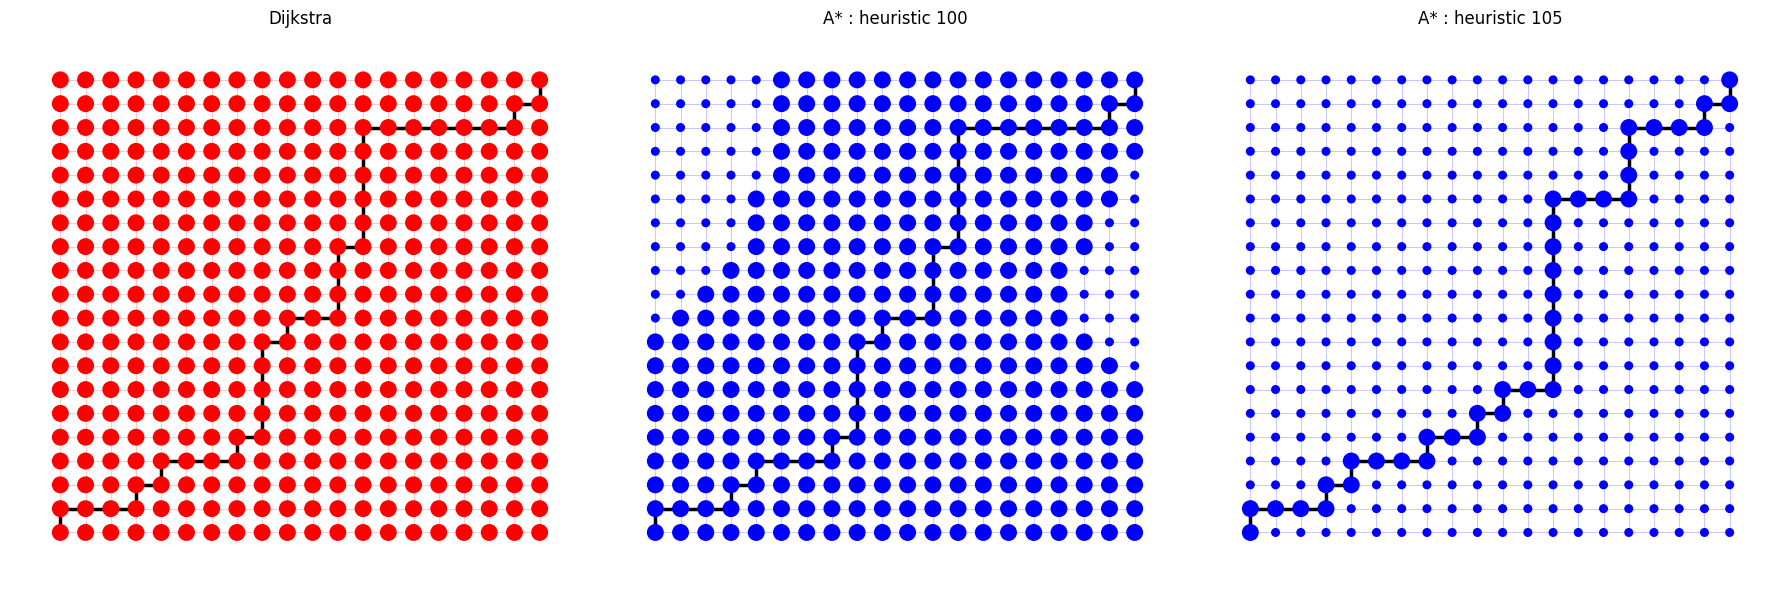

In [94]:
dist_dijkstra = dijkstra_result['distance']
path_dijkstra = dijkstra_result['path']
visit_count_dijkstra = dijkstra_result['visit_count']

dist_astar = astar_result['distance']
path_astar = astar_result['path']
visit_count_astar = astar_result['visit_count']

dist_astar2 = astar_result2['distance']
path_astar2 = astar_result2['path']
visit_count_astar2 = astar_result2['visit_count']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

pos = {node: node for node in G.nodes()}

def draw_result(ax, title, path, visit_count, noed_color = 'red',edge_color='red'):
    base_size = 30
    sizes = [
        base_size + 95 * visit_count.get(node, 0)  # 방문 많이 할수록 노드 크게
        for node in G.nodes()
    ]

    ax.set_title(title)
    nx.draw_networkx_edges(G, pos, ax=ax, width=0.5, alpha=0.3, edge_color=edge_color)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=sizes, node_color=noed_color)

    # 최단 경로 강조
    if path:
        path_edges = list(zip(path[:-1], path[1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, ax=ax, width=2.5)
    ax.axis("off")

draw_result(axes[0], "Dijkstra", path_dijkstra, visit_count_dijkstra,noed_color='red' ,edge_color="red")
draw_result(axes[1], "A* : heuristic 100",       path_astar,     visit_count_astar, noed_color='blue' ,edge_color="blue")
draw_result(axes[2], "A* : heuristic 105",       path_astar2,     visit_count_astar2, noed_color='blue' ,edge_color="blue")

plt.tight_layout()
plt.show()

- A*의 경우, 휴리스틱 스케일을 보통 가중치의 하한값 정도로 맞춰줌. (위 예시에서는 100)

- 휴리스틱 스케일이 작을수록 다익스트라에 수렴(정확도 보장, 탐색범위 넓어짐, 탐색속도 증가)

- 휴리스틱 스케일이 커질수록 휴리스틱의 탐색조건을 따라감(맨해튼이나 유클리드라면 직선거리에 가깝게 변화, 탐색범위 좁아짐, 탐색속도 감소)

#### 3-3. 네트워크 규모 및 복잡성 확장

##### 3-3-1. random geometric graph

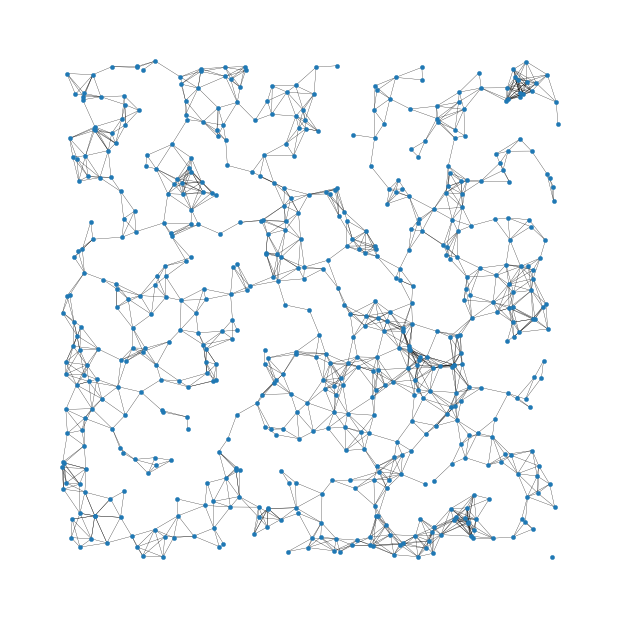

In [177]:
def build_random_geo_graph(n=200, radius=0.15,r_min=0, seed=0):
    """
    n개 노드, radius 기준으로 random geometric graph 생성
    엣지 weight는 유클리드 거리로 설정
    """
    G = nx.random_geometric_graph(n, radius, seed=seed)

    pos = nx.get_node_attributes(G, "pos")  # {node: (x, y)}
    
    edges_to_remove = []
    # 엣지 가중치 = 유클리드 거리
    for u, v in G.edges():
        (x1, y1) = pos[u]
        (x2, y2) = pos[v]
        dist = math.hypot(x1 - x2, y1 - y2)
        G.edges[u, v]["weight"] = dist
        if dist < r_min:
            edges_to_remove.append((u, v))
            
    G.remove_edges_from(edges_to_remove)
        
    return G

# 그래프 만들기
G = build_random_geo_graph(n=600, radius=0.06,r_min=0.02,  seed=0)
pos = nx.get_node_attributes(G, "pos")

# 시각화
plt.figure(figsize=(6, 6))
nx.draw(
    G,
    pos,
    node_size=10,
    linewidths=0.2,
    width=0.2,
)
plt.axis("equal")
plt.show()

In [178]:
nodes_sorted_by_x = sorted(pos.items(), key=lambda kv: kv[1][0])
source = nodes_sorted_by_x[0][0]   # 가장 왼쪽
target = nodes_sorted_by_x[-1][0]  # 가장 오른쪽

In [179]:
## Dijkstra와 A*의 비교

## Dijkstra 알고리즘의 최단거리, 방문노드수, 실행시간 
def dijkstra_with_stats(G, source, target, weight="weight"): 
    """
    다익스트라: 최단거리, 방문 노드 수, 실행시간 리턴
    """
    start_t = time.perf_counter() ##함수 실행 시작지점
    prev = {}
    dist = {source: 0.0} #출발지점
    visited = set() #확정된 최단거리
    pq = [(0.0, source)] #우선순위 큐
    visited_count = 0
    visit_count = defaultdict(int) ## 탐색한 순서 기록

    while pq:
        d_u, u = heapq.heappop(pq) ## 우선순위 큐를 끄집어냄 (거리, 노드)
        if u in visited:
            continue
        visited.add(u) #기존 최단거리 경로에서 우선순위 큐를 추가
        visited_count += 1 #탐색한 노드 수 누적시킴
        visit_count[u] += 1 #방문한 노드에 따라 누적

        if u == target: #목적지점에 다다르면 루프 종료
            break

        for v in G.neighbors(u): ## 현재 큐의 이웃 노드
            w_uv = G[u][v].get(weight, 1.0) # 현재의 큐에서 이웃 노드까지의 엣지 가중치
            alt = d_u + w_uv ## 기존 최단거리에 가중치를 추가
            if alt < dist.get(v, float("inf")): # u에서 v로 가중치로 이동한거리(alt) vs v까지의 최단 거리(dist.get)
                dist[v] = alt ## alt가 짧으면 갱신
                prev[v] = u
                heapq.heappush(pq, (alt, v)) ## 우선순위 큐를 갱신

    end_t = time.perf_counter() ##함수 실행 끝지점

    def reconstruct_path(prev, source, target):
        path = []
        cur = target
        while cur != source:
            path.append(cur)
            cur = prev[cur]
        path.append(source)
        return path[::-1]

    return {
        "distance": dist.get(target, float("inf")),
        "visited": visited_count,
        "visit_count": visit_count,
        "time_sec": end_t - start_t,
        "path": reconstruct_path(prev,source,target)
    }

## 엣지의 최솟값 도출
weights = [d["weight"] for _, _, d in G.edges(data=True)]
c_min = min(weights)

## 유클리디언 거리 함수
def euclidean(p, q):
    (x1, y1), (x2, y2) = pos[p], pos[q]
    return ((x1 - x2)**2 + (y1 - y2)**2) ** 0.5

## A* 알고리즘의 최단거리, 방문노드수, 실행시간 
def astar_with_stats(G, source, target, weight="weight", heuristic_scale=1.0):
    """
    A*: 최단거리, 방문 노드 수, 실행시간 리턴
    heuristic_scale은 h(n)=scale * euclidean(n,target)에 곱하는 스케일(휴리스틱 자체 가중치)
    """
    start_t = time.perf_counter() ##함수 실행 시작지점
    prev = {}
    visit_count = defaultdict(int) ## 탐색한 순서 기록
    # g: 실제 비용, f = g + h
    g = {source: 0.0} # 출발지점
    visited = set() # 확정된 최단거리
    visited_count = 0

    def h(node):
        return heuristic_scale * euclidean(node, target)
    
    pq = [(h(source), source)]  # (f, node)

    while pq:
        f_u, u = heapq.heappop(pq) ##우선순위 큐를 끄집어냄 (휴리스틱, 노드)
        if u in visited:
            continue
        visited.add(u) ##기존 최단거리 경로에서 우선순위 큐를 추가
        visited_count += 1  #탐색한 노드 수 누적시킴
        visit_count[u] += 1 #방문한 노드에 따라 누적
        if u == target: #목적지점에 다다르면 루프 종료
            break

        g_u = g[u] #현재 큐에서의 거리

        for v in G.neighbors(u): #현재 큐와 인접한 노드 v
            w_uv = G[u][v].get(weight, 1.0) ## 현재의 큐에서 이웃 노드까지의 엣지 가중치
            tentative_g = g_u + w_uv ## 기존 최단거리에 가중치를 추가

            if tentative_g < g.get(v, float("inf")): # u에서 v로 가중치로 이동한거리(tentative_g) vs v까지의 최단 거리(g.get)
                g[v] = tentative_g ##기존 최단거리에 가중치를 추가
                f_v = tentative_g + h(v)  ## 가중치에 휴리스틱을 추가
                prev[v] = u
                heapq.heappush(pq, (f_v, v)) ## 우선순위 큐를 갱신

    end_t = time.perf_counter() ##함수 실행 끝지점

        # 최단 경로 복원
    def reconstruct_path(prev, source, target):
        path = []
        cur = target
        while cur != source:
            path.append(cur)
            cur = prev[cur]
        path.append(source)
        return path[::-1]

    return {
        "distance": g.get(target, float("inf")),
        "visited": visited_count,
        "visit_count": visit_count,
        "time_sec": end_t - start_t,
        "path": reconstruct_path(prev,source,target)
    }


if __name__ == "__main__":
    # -----------------------------
    # 파라미터
    # -----------------------------

    ## 노드상 출발지점은 (0,0), 목적지점은 (19,19)
    source = nodes_sorted_by_x[0][0]   # 가장 왼쪽
    target = nodes_sorted_by_x[-1][0]  # 가장 오른쪽

    # 휴리스틱 스케일은 대략 평균 가중치 정도로 맞춰줌
    
    # 다익스트라
    dijkstra_result = dijkstra_with_stats(G, source, target)
    print("=== Dijkstra ===")
    print(f"distance : {dijkstra_result['distance']:.3f}")
    print(f"visited  : {dijkstra_result['visited']}")
    print(f"time_sec : {dijkstra_result['time_sec']:.6f}")

    # A*
    astar_result = astar_with_stats(G, source, target, heuristic_scale=c_min)
    print("\n=== A* heuristic min===")
    print(f"distance : {astar_result['distance']:.3f}")
    print(f"visited  : {astar_result['visited']}")
    print(f"time_sec : {astar_result['time_sec']:.6f}")

    # A* 휴리스틱이 증가하는 경우
    astar_result2 = astar_with_stats(G, source, target, heuristic_scale=c_min+1)
    print("\n=== A* heuristic min+1===")
    print(f"distance : {astar_result2['distance']:.3f}")
    print(f"visited  : {astar_result2['visited']}")
    print(f"time_sec : {astar_result2['time_sec']:.6f}")


    # 두 알고리즘 결과 비교 (거리)
    print("\n=== Compare ===")
    print(f"same distance? {abs(dijkstra_result['distance'] - astar_result['distance']) < 1e-6}")


=== Dijkstra ===
distance : 1.563
visited  : 599
time_sec : 0.002711

=== A* heuristic min===
distance : 1.563
visited  : 599
time_sec : 0.005208

=== A* heuristic min+1===
distance : 1.563
visited  : 351
time_sec : 0.002018

=== Compare ===
same distance? True


In [180]:
c_min

0.020073724495124866

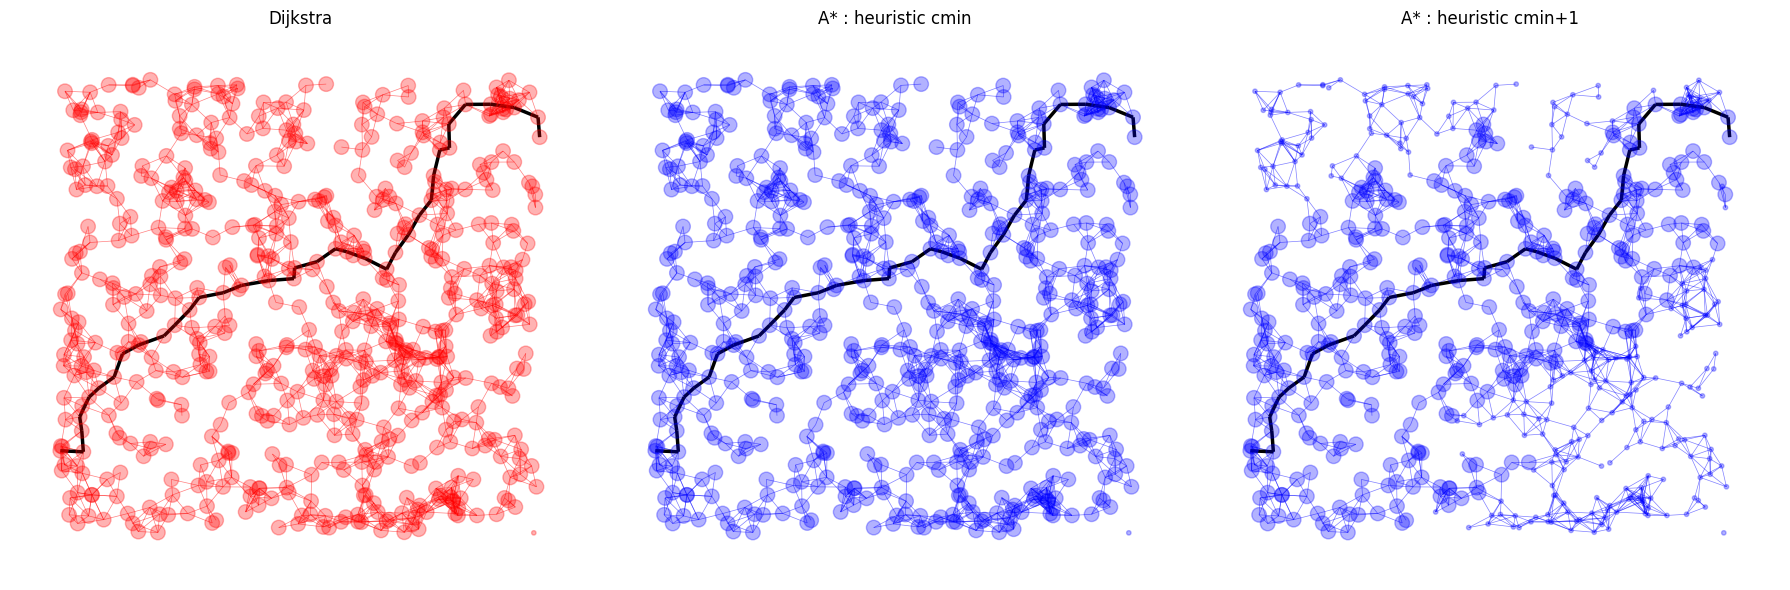

In [183]:
dist_dijkstra = dijkstra_result['distance']
path_dijkstra = dijkstra_result['path']
visit_count_dijkstra = dijkstra_result['visit_count']

dist_astar = astar_result['distance']
path_astar = astar_result['path']
visit_count_astar = astar_result['visit_count']

dist_astar2 = astar_result2['distance']
path_astar2 = astar_result2['path']
visit_count_astar2 = astar_result2['visit_count']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

def draw_result(ax, title, path, visit_count, node_color = 'red',edge_color='red'):
    base_size = 10
    sizes = [
        base_size + 100 * visit_count.get(node, 0)  # 방문 많이 할수록 노드 크게
        for node in G.nodes()
    ]

    ax.set_title(title)
    nx.draw_networkx_edges(G, pos, ax=ax, width=0.5, alpha=0.5, edge_color=edge_color)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=sizes, alpha=0.3,node_color=node_color)

    # 최단 경로 강조
    if path:
        path_edges = list(zip(path[:-1], path[1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, ax=ax, width=2.5)
    ax.axis("off")

draw_result(axes[0], "Dijkstra", path_dijkstra, visit_count_dijkstra,node_color='red' ,edge_color="red")
draw_result(axes[1], "A* : heuristic cmin",       path_astar,     visit_count_astar, node_color='blue' ,edge_color="blue")
draw_result(axes[2], "A* : heuristic cmin+1",       path_astar2,     visit_count_astar2, node_color='blue' ,edge_color="blue")

plt.tight_layout()
plt.show()